In [1]:
import os
import sys
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.4-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

## Create SparkContext, SparkSession
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = sc.textFile("/user/jayantm/Uber/StreamData10/Data*/")

In [4]:
data.count()

7247

In [5]:
data.take(3)

[u'(\'"2/28/2017 0:00:00",40.8039,-73.9678,"B02764"\', 5)',
 u'(\'"2/28/2017 0:00:00",40.7319,-73.9964,"B02764"\', 3)',
 u'(\'"2/28/2017 0:03:00",40.7497,-73.9875,"B02764"\', 3)']

In [6]:
import re
lines = data.map(lambda x: re.sub('\(|\)', '', str(x)))

In [7]:
lines.take(3)

['\'"2/28/2017 0:00:00",40.8039,-73.9678,"B02764"\', 5',
 '\'"2/28/2017 0:00:00",40.7319,-73.9964,"B02764"\', 3',
 '\'"2/28/2017 0:03:00",40.7497,-73.9875,"B02764"\', 3']

In [8]:
data1 = lines.map(lambda line: line.split(','))

In [9]:
data1.take(2)

[['\'"2/28/2017 0:00:00"', '40.8039', '-73.9678', '"B02764"\'', ' 5'],
 ['\'"2/28/2017 0:00:00"', '40.7319', '-73.9964', '"B02764"\'', ' 3']]

In [10]:
clusterList = data1.map(lambda line : int(line[4])).collect()

In [11]:
clusterList[:5]

[5, 3, 3, 0, 0]

In [13]:
def constructBarGraph(listDetails,xLabel,yLabel):
    barGraphDict = dict((x,listDetails.count(x)) for x in set(listDetails))
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(xLabel)
    ax1.set_ylabel(yLabel)
    plt.bar(range(len(barGraphDict)), barGraphDict.values(), align='center')
    plt.xticks(range(len(barGraphDict)), barGraphDict.keys())
    plt.show()

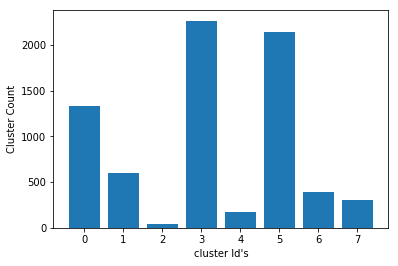

In [14]:
## Plot the the clusternumber vs count of data poinst in each cluster
constructBarGraph(clusterList, 'cluster Id\'s','Cluster Count')

In [15]:
hr = data1.map(lambda line : line[0]).map(lambda x: re.sub('\'', '', str(x)))

In [16]:
hr.take(2)

['"2/28/2017 0:00:00"', '"2/28/2017 0:00:00"']

In [17]:
def covnertTSToHour(value):
    if value and not value.isspace():
        #value = "2/28/2017 0:00:00"
        time = value.split(" ")[1].split(":")
        return int(time[0])

In [18]:
hrlist = hr.map(lambda hr:covnertTSToHour(hr)).collect()

In [19]:
hrlist[:5]

[0, 0, 0, 0, 0]

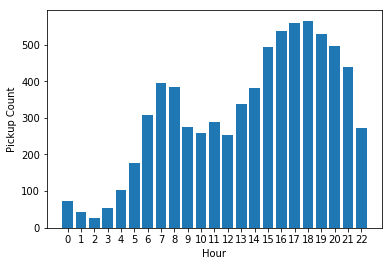

In [20]:
## plot the bar chart for hour of day vs count of pick-up requests for each hour
## Plot the hour list details 
constructBarGraph(hrlist,'Hour','Pickup Count')

In [21]:
import pandas as pd

In [23]:
FinalData = pd.DataFrame(
    {'Cluster_Id': clusterList,
     'Hour_of_Day': hrlist     
    })

In [24]:
FinalData.head(6)

,Cluster_Id,Hour_of_Day
0,5,0
1,3,0
2,3,0
3,0,0
4,0,0
5,1,0


In [25]:
ClusterIdHourData = FinalData.groupby(['Cluster_Id','Hour_of_Day'])

In [26]:
len(ClusterIdHourData)

177

In [27]:
type(ClusterIdHourData)

pandas.core.groupby.DataFrameGroupBy

In [28]:
## Convert the above as a data frame
ClusterHourFrame = ClusterIdHourData.size().to_frame()

In [29]:
type(ClusterHourFrame)

pandas.core.frame.DataFrame

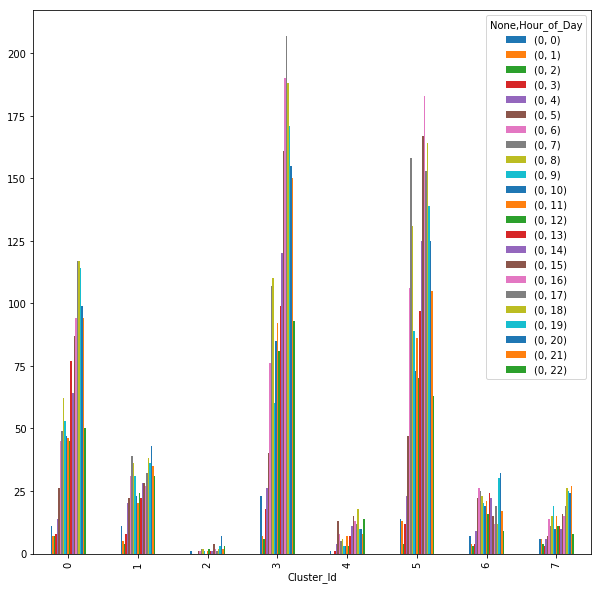

In [30]:
## Stacked bar chart for the above
ClusterHourFrame.unstack(level=-1).plot(kind='bar', figsize = (10,10))

In [31]:
## Filter the records based on the clusterId 
def drawPlotPerGraph(clusterNo):
    Data0Rec = FinalData[FinalData['Cluster_Id']==clusterNo]
    ax = Data0Rec.groupby(['Hour_of_Day']).size().to_frame().unstack(level=-1).plot(kind='bar', figsize = (10,10),title='Cluster ' + str(clusterNo)  + ' Hour Of Day Distribution')
    ax.set_xlabel("Hour Of Day")
    ax.set_ylabel("Cluster Count")
    ax.set_xticklabels(range(1,24))
    plt.show()

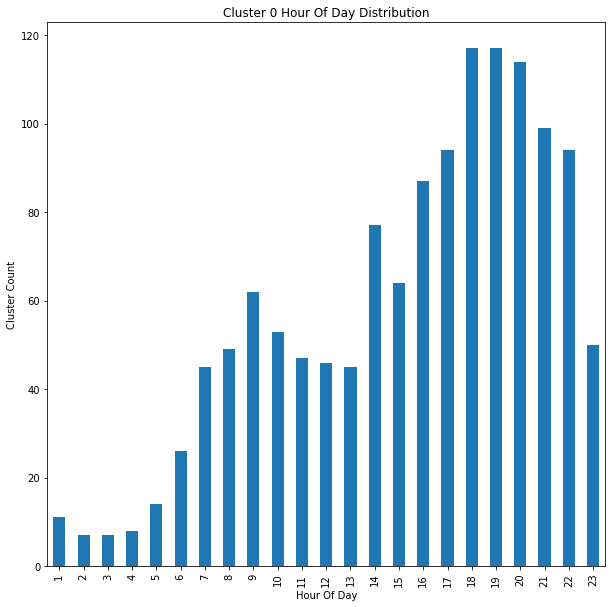

In [32]:
## count for each hour for cluster 0
drawPlotPerGraph(0)

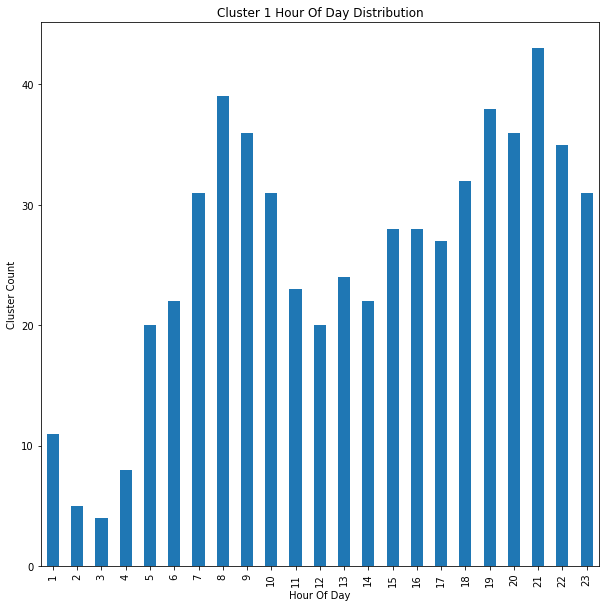

In [33]:
drawPlotPerGraph(1)